# Libraries

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.linalg import expm
import itertools
import time
import sys
sys.path.append('./../content/equadratures')
sys.path.append('./../src/Diff.py')
import equadratures as eq
from scipy.integrate import solve_ivp
from IPython.display import clear_output
import os
from Diff import *
import matplotlib.lines as mlines

#CVXPY and MOSEK installation
import cvxpy as cp
from cvxpy.reductions.solvers import defines as slv_def
slv_def.INSTALLED_SOLVERS.append('MOSEK')

# Graph initialization

In [21]:
twitter = nx.read_weighted_edgelist('../data/congress_network/congress.edgelist', )

In [22]:
coms = nx.community.asyn_fluidc(twitter, 2, seed=0)

In [8]:
def graph_perm_matrix(coms): 
    final_index = []
    coms_new = []
    for com in coms:
        coms_new.append(list(com))
        final_index+= [int(i) for i in com]
    initial_index = [i for i in range(len(final_index))]
    P = np.zeros((len(final_index), len(final_index)), dtype=int)

    P[final_index, initial_index] = 1
    return P, coms_new

In [11]:
def initialize_graph(G, num_coms=2, activ_ratio = 0.2):

  A = nx.adjacency_matrix(G).todense()
  L = nx.laplacian_matrix(G).toarray()

  n = G.number_of_nodes()
  x0 = np.ones(n)
  coms = nx.community.asyn_fluidc(G, num_coms, seed=0)
  P, coms = graph_perm_matrix(coms)
  A = P @ A @ P.T
  L = P @ L @ P.T
  activ = np.random.choice(n, int(activ_ratio*n))
  x0[activ] = 100
  sizes = []
  coms_list = []
  for com in coms:
    sizes.append(len(list(com)))
    coms_list.append(com)

  return G, n, A, L, coms_list, sizes, x0


In [23]:
from random import randint
partition = dict()
for id, com in enumerate(nx.community.asyn_fluidc(twitter, 2, seed=0)):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        partition[node] = id
# plt.figure(figsize=(15, 9))
# plt.axis("off")
# nx.draw_networkx(
#     twitter, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
# )

In [9]:
#check if it is a partition
partition.items()
class0 = []
class1 = []
for item in partition.items():
    if item[1] == 0:
        class0.append(int(item[0]))
    elif item[1] == 1:
        class1.append(int(item[0]))


In [49]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities, hypergraph = _position_communities(g, partition, scale=2)
    pos_nodes = _position_nodes(g, partition, scale=3)

    # combine positions
    pos = dict()
    class0 = []
    class1 = []
    for node in g.nodes():
        pos[node] = pos_communities[node]+ pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos, hypergraph

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [50]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)
drop_weights(twitter)
pos= community_layout(twitter, partition)

In [51]:
color1 = "#%06X" % randint(0, 0xFFFFFF)
color2 ="#%06X" % randint(0, 0xFFFFFF)
colors_int = dict()
for node, com in pos.items():
    if com[1]>0:
        colors_int[int(node)] = color1
    else:
        colors_int[int(node)] = color2

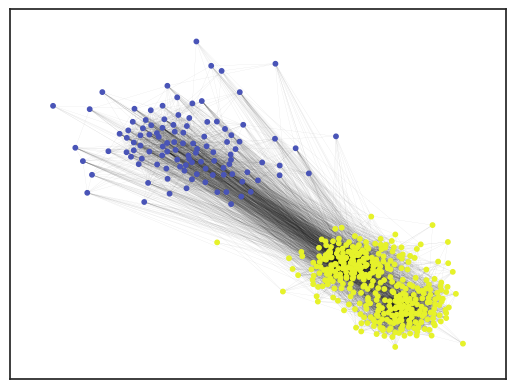

In [53]:
nx.draw_networkx_nodes(twitter, pos, node_size=10, node_color=list(colors_int.values()))
nx.draw_networkx_edges(twitter,pos, alpha=0.2, width=0.1)

In [61]:
plt.show()
plt.savefig("twitter_plot.pdf", format="pdf")

<Figure size 640x480 with 0 Axes>